<a href="https://colab.research.google.com/github/lwarode/ML_Lab-1_Group-C/blob/main/3_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup

In [12]:
# Load packages
import pandas as pd
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, auc, precision_score, recall_score, balanced_accuracy_score, f1_score, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, RepeatedKFold, cross_val_score, StratifiedKFold, cross_validate, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVC, LinearSVC
from scipy.stats import randint
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [13]:
# Function for exporting figures
os.makedirs("figures", exist_ok = True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join("figures", fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 2. Get the Data

### 2.1 Download the data

In [4]:
# Download the data
vdem_2022_repl = pd.read_csv("https://raw.githubusercontent.com/vdeminstitute/part/main/create-data/output/part-v12.csv")
vdem_2022_repl = vdem_2022_repl.sort_values(["year", "country_name"], ascending=True) # for Walking-Forward-Validation

### 2.2 Create training and testing set

In [5]:
# Create training data set (1970 to 2015)
train_data = vdem_2022_repl[vdem_2022_repl['year']<2016]

# Create test data set (2016 to 2020)
test_data = vdem_2022_repl[(vdem_2022_repl['year']>2015) & (vdem_2022_repl['year']<2021)]

In [ ]:
# Create training data set (1970 to 2016)
#train_data = vdem_2022_repl[vdem_2022_repl['year']<2017]

# Create test data set (2017 to 2021)
#test_data = vdem_2022_repl[(vdem_2022_repl['year']>2016) & (vdem_2022_repl['year']<2022)]

In [ ]:
len(train_data)

7176

In [ ]:
len(test_data)

845

In [ ]:
train_data.head()

In [ ]:
test_data.head()

### 2.3 Select features and target variables

In [6]:
# Columns to be dropped
columns_drop = ["gwcode", "year", "country_name", "country_text_id", "country_id",
             "v2x_regime", "v2x_regime_amb", "any_neg_change", "lagged_v2x_regime_asCharacter", "lagged_v2x_regime_asFactor", "any_neg_change_2yr", "lagged_v2x_regime", "lagged_v2x_regime_amb.5"]

# For training data  
X_train = train_data.drop(columns = columns_drop, axis=1) # Removes several identifier variables not needed for modeling
y_train = train_data.any_neg_change_2yr.values

# For test_data
X_test = test_data.drop(columns = columns_drop, axis=1) # Removes several identifier variables not needed for modeling
y_test = test_data.any_neg_change_2yr.values


### 2.4 Explore the training data

In [ ]:
train_data.describe()

,gwcode,year,country_id,any_neg_change,any_neg_change_2yr,v2x_regime,v2x_regime_amb,lagged_v2x_regime,lagged_is_closed_autocracy,lagged_currentRegimeDuration,...,lagged_internal_confl_part_minor,lagged_war,lagged_war_major,lagged_war_minor,lagged_any_conflict,lagged_any_conflict_major,lagged_any_conflict_minor,lagged_ext_conf,lagged_ext_conf_major,lagged_ext_conf_minor
count,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,...,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000,7176.000000
mean,462.831243,1993.417921,92.175725,0.019370,0.037625,1.311037,3.918339,1.291667,0.304766,26.349359,...,0.165134,0.032887,0.018813,0.014493,0.280797,0.147854,0.172938,0.280797,0.147854,0.172938
std,240.669059,13.187100,55.648623,0.137832,0.190302,1.099367,3.225338,1.101822,0.460340,27.529428,...,0.371327,0.178354,0.135873,0.119519,0.449420,0.354980,0.378220,0.449420,0.354980,0.378220
min,2.000000,1970.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,305.000000,1982.000000,47.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,461.000000,1994.000000,87.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,663.000000,2005.000000,132.000000,0.000000,0.000000,2.000000,7.000000,2.000000,1.000000,36.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,950.000000,2015.000000,210.000000,1.000000,1.000000,3.000000,9.000000,3.000000,1.000000,115.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Looking for correlations
corr_matrix = train_data.corr()
corr_matrix["any_neg_change_2yr"].sort_values(ascending=False)

any_neg_change_2yr                     1.000000
any_neg_change                         0.710796
lagged_v2xlg_leginter                  0.239250
lagged_pt_coup_num                     0.199359
lagged_pt_coup                         0.198087
                                         ...   
lagged_diff_year_prior_v2x_elecoff    -0.130874
lagged_diff_year_prior_v2xlg_legcon   -0.130956
lagged_diff_year_prior_v2lgbicam      -0.133983
lagged_is_jud                               NaN
lagged_diff_year_prior_is_jud               NaN
Name: any_neg_change_2yr, Length: 461, dtype: float64

## 3. Model 1: Gradient Boosted Forest

### 3.1 Fit Plain Model on Training Set

In [ ]:
# Build a plain model prior to hyperparameter tuning (XGBoost without parameters)
model_xgb_plain = xgb.XGBClassifier(objective ='binary:logistic')

In [ ]:
# Fit the plain model on training set
model_xgb_plain.fit(X_train, y_train)

XGBClassifier()

#### Evaluate Training Scores

In [ ]:
# For plain model without tuned hyperparameters
y_train_hat_xgb_plain = model_xgb_plain.predict(X_train)
y_train_hat_probs_xgb_plain = model_xgb_plain.predict_proba(X_train)[:,1]

train_balanced_accuracy_xgb_plain = balanced_accuracy_score(y_train, y_train_hat_xgb_plain)*100
train_auc_roc_xgb_plain = roc_auc_score(y_train, y_train_hat_probs_xgb_plain)*100
train_recall_xgb_plain = recall_score(y_train, y_train_hat_xgb_plain)*100
train_precision_xgb_plain = precision_score(y_train, y_train_hat_xgb_plain)*100
train_f1_xgb_plain = f1_score(y_train, y_train_hat_xgb_plain)*100
train_f1_weighted_xgb_plain = f1_score(y_train, y_train_hat_xgb_plain, average='weighted')*100

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat_xgb_plain))
print('Training Balanced Accuracy: %.4f %%' % train_balanced_accuracy_xgb_plain)
print('Training AUC: %.4f %%' % train_auc_roc_xgb_plain)
print('Training Recall: %.4f %%' % train_recall_xgb_plain)
print('Training Precision: %.4f %%' % train_precision_xgb_plain)
print('Training F1: %.4f %%' % train_f1_xgb_plain)
print('Training F1 Weighted: %.4f %%' % train_f1_weighted_xgb_plain)


Confusion matrix:
 [[6903    3]
 [ 193   77]]
Training Balanced Accuracy: 64.2375 %
Training AUC: 98.8287 %
Training Recall: 28.5185 %
Training Precision: 96.2500 %
Training F1: 44.0000 %
Training F1 Weighted: 96.5458 %


### 3.2 Hyperparameter Tuning

#### Randomized grid search

In [ ]:
# parameter for pipepline (using standardization)
params = {
        'xgb__n_estimators': [60, 80, 100, 120, 140, 160, 180],
        'xgb__learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__min_child_weight': randint(low=1, high=10),
        'xgb__gamma': [0, 0.5, 1, 1.5, 2, 5],
        'xgb__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__max_delta_step': randint(low=1, high=10),
        'xgb__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'xgb__max_depth': randint(low=3, high=10),
        'xgb__reg_alpha': [0, 0.5, 1],
        'xgb__reg_lambda': [0, 0.5, 1],
        }

In [ ]:
params = {
        'n_estimators': [60, 80, 100, 120, 140, 160, 180],
        'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'min_child_weight': randint(low=1, high=10),
        'gamma': [0, 0.5, 1, 1.5, 2, 5],
        'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'max_delta_step': randint(low=1, high=10),
        'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
        'max_depth': randint(low=3, high=10),
        'reg_alpha': [0, 0.5, 1],
        'reg_lambda': [0, 0.5, 1],
        }

In [ ]:
#xgb_model_random = xgb.XGBClassifier(objective ='binary:logistic', random_state = 42)
xgb_model_random = Pipeline([("scaler", StandardScaler()), ("xgb", xgb.XGBClassifier(objective ='binary:logistic', random_state = 42)),],)

random_search_xgb = RandomizedSearchCV(xgb_model_random, 
                                   param_distributions = params, 
                                   n_iter = 70, 
                                   scoring = 'f1',  
                                   cv = 5,
                                   random_state=42)

random_search_xgb.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('xgb',
                                              XGBClassifier(random_state=42))]),
                   n_iter=70,
                   param_distributions={'xgb__colsample_bytree': [0.5, 0.6, 0.7,
                                                                  0.8, 0.9,
                                                                  1.0],
                                        'xgb__gamma': [0, 0.5, 1, 1.5, 2, 5],
                                        'xgb__learning_rate': [0.1, 0.2, 0.3,
                                                               0.4, 0.5, 0.6,
                                                               0.7, 0.8, 0.9,
                                                               1.0],
                                        'xgb__max_delta_step': <scipy.stats._distn_infrastructure...
                         

The best hyperparameter combination found:

In [ ]:
print('\n Best hyperparameters:')
print(random_search_xgb.best_params_)


 Best hyperparameters:
{'xgb__colsample_bytree': 0.8, 'xgb__gamma': 0, 'xgb__learning_rate': 0.7, 'xgb__max_delta_step': 4, 'xgb__max_depth': 5, 'xgb__min_child_weight': 5, 'xgb__n_estimators': 140, 'xgb__reg_alpha': 1, 'xgb__reg_lambda': 0, 'xgb__subsample': 0.8}


In [ ]:
print('\n Best estimator:')
print(random_search_xgb.best_estimator_)


 Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('xgb',
                 XGBClassifier(colsample_bytree=0.8, learning_rate=0.7,
                               max_delta_step=4, max_depth=5,
                               min_child_weight=5, n_estimators=140,
                               random_state=42, reg_alpha=1, reg_lambda=0,
                               subsample=0.8))])


In [ ]:
# best_random_xgb_model = random_search.best_estimator_

#### Optional: Grid search

In [ ]:
# Commented because it takes a VERY LONG time to run.

# param_grid = {
#         'n_estimators': randint(low=2, high=150),
#         'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'min_child_weight': randint(low=1, high=10),
#         'gamma': [0, 0.5, 1, 1.5, 2, 5],
#         'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'max_delta_step': randint(low=1, high=10),
#         'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
#         'max_depth': randint(low=3, high=10),
#         'reg_alpha': [0, 0.5, 1],
#         'reg_lambda': [0, 0.5, 1],
#         }
     
# xgb_model = xgb.XGBClassifier()

# xgb_grid_search = GridSearchCV(xgb_model, param_grid, cv=5,
#                                   scoring="neg_mean_squared_error",
#                                   return_train_score=True,
#                                   verbose=True,
#                                   n_jobs=-1)

# xgb_grid_search.fit(X_train, y_train)

Fitting 14 folds for each of 8 candidates, totalling 112 fits


GridSearchCV(cv=14, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0, 1], 'max_depth': [2, 20],
                         'n_estimators': [2, 150]},
             return_train_score=True, scoring='accuracy', verbose=True)

The best hyperparameter combination found:

In [ ]:
# xgb_grid_search.best_params_

{'learning_rate': 1, 'max_depth': 2, 'n_estimators': 2}

In [ ]:
# xgb_grid_search.best_estimator_

XGBClassifier(learning_rate=1, max_depth=2, n_estimators=2)

In [ ]:
# best_xgb_model = xgb_grid_search.best_estimator_

#### Optional: Bayesian Optimization

In [ ]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [ ]:
# Initialize domain space for range of values

space={'n_estimators': hp.randint("n_estimators", 150),
       'learning_rate' : hp.uniform('learning_rate', 0.1,1.0),
       'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
       'gamma': hp.uniform ('gamma', 0,5),
       'subsample' : hp.uniform('subsample', 0.5,1),
       'max_delta_step': hp.quniform("max_delta_step", 1, 10, 1),
       'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
       'max_depth': hp.quniform("max_depth", 3, 10, 1),
       'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
       'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'seed': 0
       }

In [ ]:
# Define objective function

def objective(space):
    clf = xgb.XGBClassifier(
                    n_estimators = int(space['n_estimators']),
                    learning_rate=int(space['learning_rate']),
                    min_child_weight=int(space['min_child_weight']),
                    gamma = space['gamma'],
                    subsample=int(space['subsample']),
                    max_delta_step=int(space['max_delta_step']),
                    colsample_bytree=int(space['colsample_bytree']),
                    max_depth = int(space['max_depth']),
                    reg_alpha = int(space['reg_alpha']))
    
    evaluation = [( X_train, y_train), ( X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set = evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    
    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
# Optimization algorithm

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

  0%|          | 0/100 [00:00<?, ?it/s, best loss: ?]


ValueError: ignored

In [ ]:
# Print Results

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

### 3.4 Fit Tuned Model on Training Set

In [16]:
# Best model according to Hyperparameter tuning
best_random_xgb_model = xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.7, gamma=1.5, learning_rate=0.8,
              max_delta_step=6, min_child_weight=8, n_estimators=120, reg_alpha=1, reg_lambda=0, subsample=0.8, max_depth=7)
#best_random_xgb_model = Pipeline([("scaler", StandardScaler()), ("xgb", xgb.XGBClassifier(objective ='binary:logistic', colsample_bytree=0.7, gamma=1.5, learning_rate=0.8,
              #max_delta_step=6, min_child_weight=8, n_estimators=120, reg_alpha=1, reg_lambda=0, subsample=0.8, max_depth=7)),],)

# new hyperparameter tuning (StandardScaler)
#best_random_xgb_model = Pipeline(steps=[('scaler', StandardScaler()),
                #('xgb', XGBClassifier(colsample_bytree=0.8, learning_rate=0.7, max_delta_step=4, max_depth=5, min_child_weight=5, n_estimators=140, random_state=42, reg_alpha=1, reg_lambda=0, subsample=0.8))])

# Fit the tuned model on training set
best_random_xgb_model.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7, gamma=1.5, learning_rate=0.8,
              max_delta_step=6, max_depth=7, min_child_weight=8,
              n_estimators=120, reg_alpha=1, reg_lambda=0, subsample=0.8)

#### Evaluate Training Scores

In [17]:
y_train_hat_xgb = best_random_xgb_model.predict(X_train)
y_train_hat_probs_xgb = best_random_xgb_model.predict_proba(X_train)[:,1]

train_balanced_accuracy_xgb = balanced_accuracy_score(y_train, y_train_hat_xgb)*100
train_auc_roc_xgb = roc_auc_score(y_train, y_train_hat_probs_xgb)*100
train_recall_xgb = recall_score(y_train, y_train_hat_xgb)*100
train_precision_xgb = precision_score(y_train, y_train_hat_xgb)*100
train_f1_xgb = f1_score(y_train, y_train_hat_xgb)*100
train_f1_weighted_xgb = f1_score(y_train, y_train_hat_xgb, average='weighted')*100

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat_xgb))
print('Training Balanced Accuracy: %.4f %%' % train_balanced_accuracy_xgb)
print('Training AUC: %.4f %%' % train_auc_roc_xgb)
print('Training Recall: %.4f %%' % train_recall_xgb)
print('Training Precision: %.4f %%' % train_precision_xgb)
print('Training F1: %.4f %%' % train_f1_xgb)
print('Training F1 Weighted: %.4f %%' % train_f1_weighted_xgb)

Confusion matrix:
 [[6903    3]
 [   9  261]]
Training Balanced Accuracy: 98.3116 %
Training AUC: 99.9946 %
Training Recall: 96.6667 %
Training Precision: 98.8636 %
Training F1: 97.7528 %
Training F1 Weighted: 99.8319 %


#### Visualize results

Saving figure pred_prob_xgb


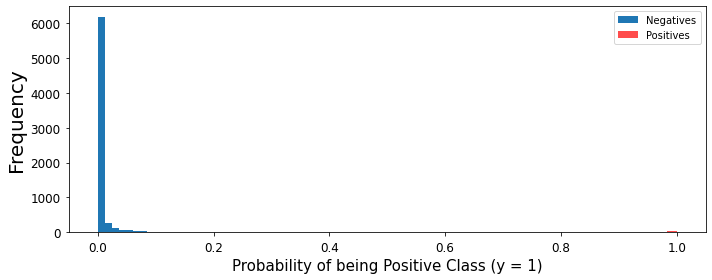

In [ ]:
# Histogram of predicted probabilities ("risk estimates") from Gradient Boosted Forest Model
plt.figure(figsize=(10,4))
#plt.suptitle('Predicted probabilities from Gradient Boosted Forest Model', fontsize=15)
plt.hist(y_train_hat_probs_xgb[y_train==0], bins=50, label='Negatives')
plt.hist(y_train_hat_probs_xgb[y_train==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class (y = 1)', fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=12, pad=5)
save_fig("pred_prob_xgb")
plt.show() 

### 3.4 Cross-Validation

#### 3.4.1 K-Fold Cross-Validation

In [28]:
cv = RepeatedKFold(n_splits = 7, n_repeats = 2)

In [ ]:
best_random_model_xgb_cv = cross_validate(best_random_xgb_model, X_train, y_train, scoring = ["balanced_accuracy", "roc_auc", "recall", "f1", "f1_weighted"], cv = cv)

In [ ]:
print(np.sum(best_random_model_xgb_cv["test_balanced_accuracy"]) / len(best_random_model_xgb_cv["test_balanced_accuracy"]))
print(np.sum(best_random_model_xgb_cv["test_roc_auc"]) / len(best_random_model_xgb_cv["test_roc_auc"]))
#print(np.sum(best_random_model_xgb_cv["test_recall"]) / len(best_random_model_xgb_cv["test_recall"]))
print(np.sum(best_random_model_xgb_cv["test_f1"]) / len(best_random_model_xgb_cv["test_f1"]))
print(np.sum(best_random_model_xgb_cv["test_f1_weighted"]) / len(best_random_model_xgb_cv["test_f1_weighted"]))

0.6414187757430857
0.9308440951673168
0.3923716011150261
0.9609726495862994


#### 3.4.2 Walk-Forward-Validation

In [30]:
tscv = TimeSeriesSplit(n_splits = 7)

In [ ]:
best_random_model_xgb_tscv = cross_validate(best_random_xgb_model, X_train, y_train, scoring = ["balanced_accuracy", "roc_auc", "recall", "f1", "f1_weighted"], cv = tscv)

In [ ]:
print(np.sum(best_random_model_xgb_tscv["test_balanced_accuracy"]) / len(best_random_model_xgb_tscv["test_balanced_accuracy"]))
print(np.sum(best_random_model_xgb_tscv["test_roc_auc"]) / len(best_random_model_xgb_tscv["test_roc_auc"]))
#print(np.sum(best_random_model_xgb_tscv["test_recall"]) / len(best_random_model_xgb_tscv["test_recall"]))
print(np.sum(best_random_model_xgb_tscv["test_f1"]) / len(best_random_model_xgb_tscv["test_f1"]))
print(np.sum(best_random_model_xgb_tscv["test_f1_weighted"]) / len(best_random_model_xgb_tscv["test_f1_weighted"]))

0.5575634834904756
0.7674124936664891
0.18553728018013735
0.9512182982483103


### 3.5 Assessing Feature Importance

In [18]:
feature_importances_random_xgb = best_random_xgb_model.feature_importances_

In [21]:
# Create a dataframe for the model's feature importance
feat_df_xgb = pd.DataFrame(
    feature_importances_random_xgb, columns=['feature importance'], 
    index=X_train.columns).sort_values(
    'feature importance', ascending=False)

In [ ]:
sorted(zip(feature_importances_random_xgb, X_train), reverse=True)

In [ ]:
most_important_features_xgb_20 = feat_df_xgb.nlargest(20, columns = ['feature importance']).sort_values(by = ['feature importance'], ascending=False)
print(most_important_features_xgb_20)

                                       feature importance
lagged_diff_year_prior_v2x_elecoff               0.073415
lagged_v2x_regime_amb.0                          0.038598
lagged_diff_year_prior_v2elembaut                0.023422
lagged_v2clacfree                                0.022865
lagged_diff_year_prior_v2ellocons                0.022171
lagged_diff_year_prior_v2xlg_legcon              0.018834
lagged_is_closed_autocracy                       0.017220
lagged_diff_year_prior_v2csantimv                0.015267
lagged_v2jucorrdc                                0.015054
lagged_diff_year_prior_v2xeg_eqprotec            0.013669
lagged_v2x_clphy                                 0.013051
lagged_diff_year_prior_v2x_polyarchy             0.012607
lagged_v2ellocumul                               0.011051
lagged_diff_year_prior_v2x_clpol                 0.010151
lagged_low_border_case                           0.009820
lagged_v2xnp_client                              0.009402
lagged_v2x_acc

Saving figure feat_import_xgb_bar


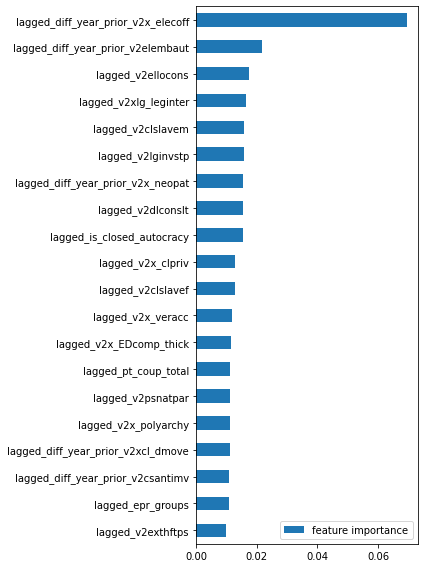

In [22]:
feat_df_xgb.nlargest(20, columns = ['feature importance']).sort_values(by = ['feature importance'], ascending=True).plot(kind='barh', figsize=(6,8))
save_fig("feat_import_xgb_bar")

In [23]:
# reduced form wiht most 10 important features
most_important_features_xgb_10 = feat_df_xgb.nlargest(10, columns = ['feature importance']).sort_values(by = ['feature importance'], ascending=False)

names_important_features_xgb_10 = most_important_features_xgb_10.index.values.tolist()

df_most_important_xgb = X_train[names_important_features_xgb_10]

Saving figure heatmap_features_xgb


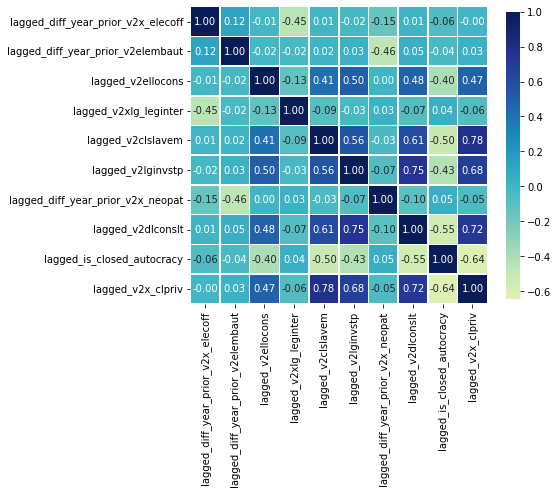

In [25]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    #plt.title('Heatmap Most Important Features Gradient Boosted Forest Model\n', fontsize=15)
    save_fig("heatmap_features_xgb")
    
correlation_heatmap(df_most_important_xgb)

## 4. Model 2: Support-Vector Machines (SVM)

### 4.1 Fit Plain Model on Training Set

In [ ]:
# Build a plain model prior to hyperparameter tuning (XGBoost without parameters)
#model_svm_plain = SVC()
#model_svm_plain = SVC(kernel = "poly", degree=3, coef0=1, C=5, probability=True)
#model_svm_plain = Pipeline ([("scaler", StandardScaler()), ("svm_clf", SVC(kernel = "poly", degree=3, coef0=1, C=5, probability=True)),],)
model_svm_plain = Pipeline([("scaler", StandardScaler()), ("svm_clf", SVC(probability=True)),],)

In [ ]:
# Fit the plain model on training set
model_svm_plain.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf',
                 SVC(C=5, coef0=1, kernel='poly', probability=True))])

#### Evaluate Training Scores

In [ ]:
# For plain model without tuned hyperparameters
y_train_hat_svm_plain = model_svm_plain.predict(X_train)
y_train_hat_probs_svm_plain = model_svm_plain.predict_proba(X_train)[:,1]

train_balanced_accuracy_svm_plain = balanced_accuracy_score(y_train, y_train_hat_svm_plain)*100
train_auc_roc_svm_plain = roc_auc_score(y_train, y_train_hat_probs_svm_plain)*100
train_recall_svm_plain = recall_score(y_train, y_train_hat_svm_plain)*100
train_precision_svm_plain = precision_score(y_train, y_train_hat_svm_plain)*100
train_f1_svm_plain = f1_score(y_train, y_train_hat_svm_plain)*100
train_f1_weighted_svm_plain = f1_score(y_train, y_train_hat_svm_plain, average='weighted')*100

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat_svm_plain))
print('Training Balanced Accuracy: %.4f %%' % train_balanced_accuracy_svm_plain)
print('Training AUC: %.4f %%' % train_auc_roc_svm_plain)
print('Training Recall: %.4f %%' % train_recall_svm_plain)
print('Training Precision: %.4f %%' % train_precision_svm_plain)
print('Training F1: %.4f %%' % train_f1_svm_plain)
print('Training F1 Weighted: %.4f %%' % train_f1_weighted_svm_plain)

Confusion matrix:
 [[6906    0]
 [  30  240]]
Training Balanced Accuracy: 94.4444 %
Training AUC: 99.9930 %
Training Recall: 88.8889 %
Training Precision: 100.0000 %
Training F1: 94.1176 %
Training F1 Weighted: 99.5701 %


### 4.2 Hyperparameter Tuning

#### Randomized grid search

In [1]:
params = {'svm__C': [0.01, 0.05, 0.1, 1, 10, 100], 'svm__degree': [3, 4, 5], 'svm__gamma': [1,0.1,0.01,0.001], 'svm__kernel': ['rbf', 'poly', 'sigmoid']}

In [7]:
svm_model_random = Pipeline([("scaler", StandardScaler()), ("svm", SVC()),],)

random_search_svm = RandomizedSearchCV(svm_model_random, 
                                   param_distributions = params, 
                                   n_iter = 70, 
                                   scoring = 'f1',  
                                   cv = 7,
                                   random_state=42)

random_search_svm.fit(X_train, y_train)

RandomizedSearchCV(cv=7,
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('svm', SVC())]),
                   n_iter=70,
                   param_distributions={'svm__C': [0.01, 0.05, 0.1, 1, 10, 100],
                                        'svm__degree': [3, 4, 5],
                                        'svm__gamma': [1, 0.1, 0.01, 0.001],
                                        'svm__kernel': ['rbf', 'poly',
                                                        'sigmoid']},
                   random_state=42, scoring='f1')

In [8]:
print('\n Best hyperparameters:')
print(random_search_svm.best_params_)


 Best hyperparameters:
{'svm__kernel': 'rbf', 'svm__gamma': 0.001, 'svm__degree': 4, 'svm__C': 100}


In [9]:
print('\n Best estimator:')
print(random_search_svm.best_estimator_)


 Best estimator:
Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=100, degree=4, gamma=0.001))])


### 4.3 Fit Tuned Model on the Training Set

#### Evaluate Training Scores

In [ ]:
# Best model according to Hyperparameter tuning
#best_random_svm_model = SVC(probability=True)
best_random_svm_model = Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=100, degree=4, gamma=0.001, probability=True))])

# Fit the tuned model on training set
best_random_svm_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm', SVC(C=100, degree=4, gamma=0.001, probability=True))])

In [ ]:
y_train_hat_svm = best_random_svm_model.predict(X_train)
y_train_hat_probs_svm = best_random_svm_model.predict_proba(X_train)[:,1]

train_balanced_accuracy_svm = balanced_accuracy_score(y_train, y_train_hat_svm)*100
train_auc_roc_svm = roc_auc_score(y_train, y_train_hat_probs_svm)*100
train_recall_svm = recall_score(y_train, y_train_hat_svm)*100
train_precision_svm = precision_score(y_train, y_train_hat_svm)*100
train_f1_svm = f1_score(y_train, y_train_hat_svm)*100
train_f1_weighted_svm = f1_score(y_train, y_train_hat_svm, average='weighted')*100

print('Confusion matrix:\n', confusion_matrix(y_train, y_train_hat_svm))
print('Training Balanced Accuracy: %.4f %%' % train_balanced_accuracy_svm)
print('Training AUC: %.4f %%' % train_auc_roc_svm)
#print('Training Recall: %.4f %%' % train_recall_svm)
#print('Training Precision: %.4f %%' % train_precision_svm)
print('Training F1: %.4f %%' % train_f1_svm)
print('Training F1 Weighted: %.4f %%' % train_f1_weighted_svm)

Confusion matrix:
 [[6904    2]
 [  10  260]]
Training Balanced Accuracy: 98.1337 %
Training AUC: 99.9964 %
Training F1: 97.7444 %
Training F1 Weighted: 99.8316 %


#### Visualize results

Saving figure pred_prob_svm


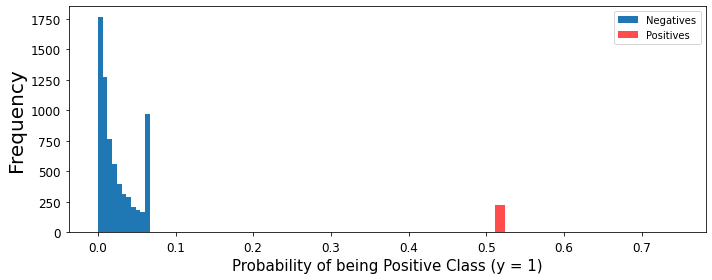

In [ ]:
# Histogram of predicted probabilities ("risk estimates") from SVM
plt.figure(figsize=(10,4))
#plt.suptitle('Predicted probabilities from SVM', fontsize=15)
plt.hist(y_train_hat_probs_svm[y_train==0], bins=50, label='Negatives')
plt.hist(y_train_hat_probs_svm[y_train==1], bins=50, label='Positives', alpha=0.7, color='r')
plt.xlabel('Probability of being Positive Class (y = 1)', fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.legend(fontsize=10)
plt.tick_params(axis='both', labelsize=12, pad=5)
save_fig("pred_prob_svm")
plt.show() 

### 4.4 Walk-Forward-Validation

#### 4.4.1 K-Fold Cross-Validation

In [ ]:
cv = RepeatedKFold(n_splits = 7, n_repeats = 2)

In [ ]:
best_random_model_svm_cv = cross_validate(best_random_svm_model, X_train, y_train, scoring = ["balanced_accuracy", "roc_auc", "recall", "f1", "f1_weighted"], cv = cv)

In [ ]:
print(np.sum(best_random_model_svm_cv["test_balanced_accuracy"]) / len(best_random_model_svm_cv["test_balanced_accuracy"]))
print(np.sum(best_random_model_svm_cv["test_roc_auc"]) / len(best_random_model_svm_cv["test_roc_auc"]))
#print(np.sum(best_random_model_svm_cv["test_recall"]) / len(best_random_model_svm_cv["test_recall"]))
print(np.sum(best_random_model_svm_cv["test_f1"]) / len(best_random_model_svm_cv["test_f1"]))
print(np.sum(best_random_model_svm_cv["test_f1_weighted"]) / len(best_random_model_svm_cv["test_f1_weighted"]))

0.6155750525209722
0.8531256522731949
0.29746225733583664
0.9517556899861457


#### 4.4.2 Walk-Forward-Validation

In [ ]:
tscv = TimeSeriesSplit(n_splits = 7)

In [ ]:
best_random_model_svm_tscv = cross_validate(best_random_svm_model, X_train, y_train, scoring = ["balanced_accuracy", "roc_auc", "recall", "f1", "f1_weighted"], cv = tscv)

In [ ]:
print(np.sum(best_random_model_svm_tscv["test_balanced_accuracy"]) / len(best_random_model_svm_tscv["test_balanced_accuracy"]))
print(np.sum(best_random_model_svm_tscv["test_roc_auc"]) / len(best_random_model_svm_tscv["test_roc_auc"]))
#print(np.sum(best_random_model_svm_tscv["test_recall"]) / len(best_random_model_svm_tscv["test_recall"]))
print(np.sum(best_random_model_svm_tscv["test_f1"]) / len(best_random_model_svm_tscv["test_f1"]))
print(np.sum(best_random_model_svm_tscv["test_f1_weighted"]) / len(best_random_model_svm_tscv["test_f1_weighted"]))

0.5559846839578492
0.7496960610489742
0.15249007674712386
0.9406388357736685


### 4.5 Assessing Feature Importance (not possible for Polynomial Kernel)

In [ ]:
best_random_svm_model["svm"]
#permutation_importance

In [ ]:
# Create a dataframe for the model's feature importance
feat_df_svm = pd.DataFrame(
    feature_importances_random_svm, columns=['feature importance'], 
    index=X_train.columns).sort_values(
    'feature importance', ascending=False)

In [ ]:
sorted(zip(feature_importances_random_svm, X_train), reverse=True)

In [ ]:
most_important_features_svm_20 = feat_df_svm.nlargest(20, columns = ['feature importance']).sort_values(by = ['feature importance'], ascending=False)
print(most_important_features_svm_20)

In [ ]:
feat_df_svm.nlargest(20, columns = ['feature importance']).sort_values(by = ['feature importance'], ascending=True).plot(kind='barh', figsize=(5,8))

In [ ]:
# reduced form wiht most 10 important features
most_important_features_svm_10 = feat_df_svm.nlargest(10, columns = ['feature importance']).sort_values(by = ['feature importance'], ascending=False)

names_important_features_svm_10 = most_important_features_svm_10.index.values.tolist()

df_most_important_svm = X_train[names_important_features_svm_10]

In [ ]:
def correlation_heatmap(train):
    correlations = train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.title('Heatmap Most Important Features SVM Model', fontsize=15)
    plt.show();
    
correlation_heatmap(df_most_important_svm)

## 5. Test the model(s) on the test data set

### 5.1 Gradient Boosted Forest Testing

In [ ]:
final_model_xgb = best_random_xgb_model

final_predictions_xgb = final_model_xgb.predict(X_test)
final_predicted_prob_xgb = final_model_xgb.predict_proba(X_test)[:,1]

In [ ]:
# yearly test forecasts on rolling basis (baseline paper approach)


Evaluate testing scores

In [ ]:
test_balanced_accuracy_xgb = balanced_accuracy_score(y_test, final_predictions_xgb)*100
test_auc_roc_xgb = roc_auc_score(y_test, final_predicted_prob_xgb)*100
test_recall_xgb = recall_score(y_test, final_predictions_xgb)*100
test_precision_xgb = precision_score(y_test, final_predictions_xgb)*100
test_f1_xgb = f1_score(y_test, final_predictions_xgb)*100
test_f1_weighted_xgb = f1_score(y_test, final_predictions_xgb, average='weighted')*100

print('Confusion matrix:\n', confusion_matrix(y_test, final_predictions_xgb))
print('Test Balanced Accuracy: %.4f %%' % test_balanced_accuracy_xgb)
print('Test AUC: %.4f %%' % test_auc_roc_xgb)
print('Test Recall: %.4f %%' % test_recall_xgb)
print('Test Precision: %.4f %%' % test_precision_xgb)
print('Test F1: %.4f %%' % test_f1_xgb)
print('Test F1 Weighted: %.4f %%' % test_f1_weighted_xgb)

Confusion matrix:
 [[783   9]
 [ 49   4]]
Test Balanced Accuracy: 53.2054 %
Test AUC: 73.7945 %
Test Recall: 7.5472 %
Test Precision: 30.7692 %
Test F1: 12.1212 %
Test F1 Weighted: 91.1407 %



#### Visualize results

Saving figure cm_xgb


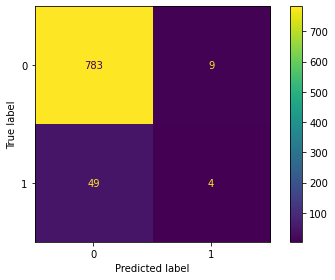

In [117]:
# Create ConfusionMatrixDisplay
cm_xgb = confusion_matrix(y_test, final_predictions_xgb)
cm_display = ConfusionMatrixDisplay(cm_xgb).plot()
save_fig("cm_xgb")

Saving figure roc_curve_xgb


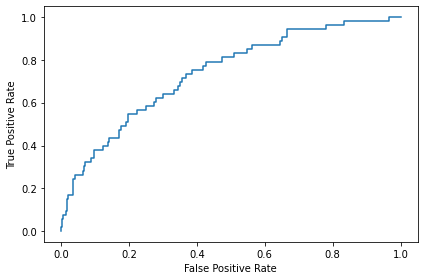

In [118]:
# Create RocCurveDisplay
fpr, tpr, _ = roc_curve(y_test, final_predicted_prob_xgb, pos_label=final_model_xgb.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
roc_display.plot()
save_fig("roc_curve_xgb")

Saving figure prec_rec_curve_xgb


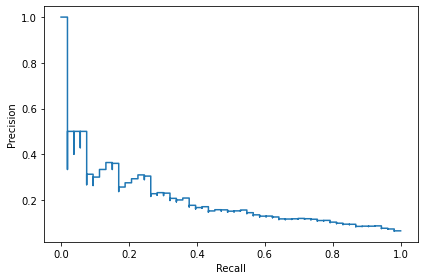

In [119]:
# Create PrecisionRecallDisplay
prec, recall, _ = precision_recall_curve(y_test, final_predicted_prob_xgb, pos_label=final_model_xgb.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)
pr_display.plot()
save_fig("prec_rec_curve_xgb")

In [ ]:
#fig, axs = plt.subplots(2)
#fig.suptitle('Vertically stacked subplots')
#axs[0].plot(RocCurveDisplay(fpr=fpr, tpr=tpr))
#axs[1].plot(PrecisionRecallDisplay(precision=prec, recall=recall))

### 5.2 Support-Vector Machines Testing

In [55]:
final_model_svm = best_random_svm_model

final_predictions_svm = final_model_svm.predict(X_test)
final_predicted_prob_svm = final_model_svm.predict_proba(X_test)[:,1]

In [56]:
test_balanced_accuracy_svm = balanced_accuracy_score(y_test, final_predictions_svm)*100
test_auc_roc_svm = roc_auc_score(y_test, final_predicted_prob_svm)*100
test_recall_svm = recall_score(y_test, final_predictions_svm)*100
test_precision_svm = precision_score(y_test, final_predictions_svm)*100
test_f1_svm = f1_score(y_test, final_predictions_svm)*100
test_f1_weighted_svm = f1_score(y_test, final_predictions_svm, average='weighted')*100

print('Confusion matrix:\n', confusion_matrix(y_test, final_predictions_svm))
print('Test Balanced Accuracy: %.4f %%' % test_balanced_accuracy_svm)
print('Test AUC: %.4f %%' % test_auc_roc_svm)
print('Test Recall: %.4f %%' % test_recall_svm)
print('Test Precision: %.4f %%' % test_precision_svm)
print('Test F1: %.4f %%' % test_f1_svm)
print('Test F1 Weighted: %.4f %%' % test_f1_weighted_svm)

Confusion matrix:
 [[760  32]
 [ 39  14]]
Test Balanced Accuracy: 61.1873 %
Test AUC: 76.5842 %
Test Recall: 26.4151 %
Test Precision: 30.4348 %
Test F1: 28.2828 %
Test F1 Weighted: 91.3191 %



#### Visualize results

Saving figure cm_svm


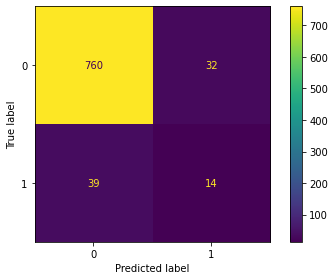

In [116]:
# Create ConfusionMatrixDisplay
cm_svm = confusion_matrix(y_test, final_predictions_svm)
cm_display = ConfusionMatrixDisplay(cm_svm).plot()
save_fig("cm_svm")

Saving figure roc_curve_svm


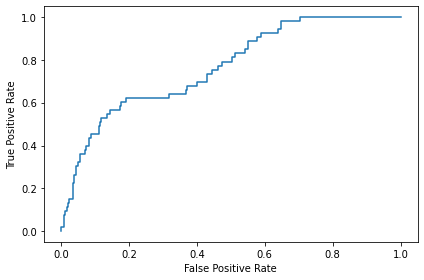

In [58]:
# Create RocCurveDisplay
fpr_svm, tpr_svm, _ = roc_curve(y_test, final_predicted_prob_svm, pos_label=final_model_svm.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr_svm, tpr=tpr_svm).plot()
save_fig("roc_curve_svm")

Saving figure prec_rec_curve_svm


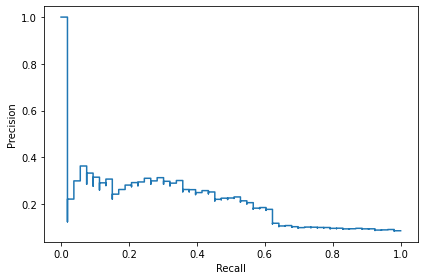

In [59]:
# Create PrecisionRecallDisplay
prec_svm, recall_svm, _ = precision_recall_curve(y_test, final_predicted_prob_svm, pos_label=final_model_svm.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec_svm, recall=recall_svm).plot()
save_fig("prec_rec_curve_svm")

## Forecasting Adverse Regime Transitions

### XGBoost

In [ ]:
# Create a forecasting data set (for example for 2021)
forecast_data_xgb = vdem_2022_repl[(vdem_2022_repl['year']>2020) & (vdem_2022_repl['year']<2022)]
X_forecast = forecast_data_xgb.drop(columns = columns_drop, axis=1) # Removes several identifier variables not needed for modeling
y_forecast = forecast_data_xgb.any_neg_change_2yr.values

In [ ]:
# Make predictions for 2021
forecasts_pred_xgb = final_model_xgb.predict(X_forecast)
forecasts_pred_prob_xgb = final_model_xgb.predict_proba(X_forecast)[:,1]

In [ ]:
# Add risk estimates (predicted probabilities) to the original forecasting dataset
forecast_data_xgb['pred_prob'] = forecasts_pred_prob_xgb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
highriskcountries_xgb = forecast_data_xgb[["year", "country_name", "pred_prob"]]
highriskcountries_xgb.set_index('country_name', inplace=True)

In [ ]:
# Show list of 20 most high-risk countries (with highest predicted probabilities of an ART)
highriskcountries_xgb.nlargest(20, columns = ['pred_prob']).sort_values(by = ['pred_prob'], ascending=False)

,year,pred_prob
country_name,,
Nepal,2021,0.684603
Mali,2021,0.680251
Ukraine,2021,0.601428
El Salvador,2021,0.522780
Ghana,2021,0.415946
Latvia,2021,0.360076
Moldova,2021,0.357541
Brazil,2021,0.355381
Estonia,2021,0.207547


Saving figure risk_forecast_2021_xgb


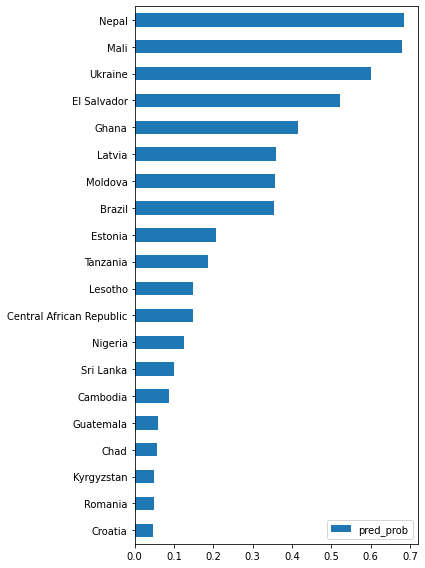

In [113]:
highriskcountries_xgb[["pred_prob"]].nlargest(20, columns = ['pred_prob']).sort_values(by = ['pred_prob'], ascending=True).plot(kind='barh', figsize=(6,8), xlabel = '')
save_fig("risk_forecast_2021_xgb")

### SVM

In [53]:
# Create a forecasting data set (for example for 2021)
forecast_data_svm = vdem_2022_repl[(vdem_2022_repl['year']>2020) & (vdem_2022_repl['year']<2022)]
X_forecast = forecast_data_svm.drop(columns = columns_drop, axis=1) # Removes several identifier variables not needed for modeling
y_forecast = forecast_data_svm.any_neg_change_2yr.values

In [60]:
# Make predictions for 2021
forecasts_pred_svm = final_model_svm.predict(X_forecast)
forecasts_pred_prob_svm = final_model_svm.predict_proba(X_forecast)[:,1]

In [61]:
# Add risk estimates (predicted probabilities) to the original forecasting dataset
forecast_data_svm['pred_prob'] = forecasts_pred_prob_svm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [62]:
highriskcountries_svm = forecast_data_svm[["year", "country_name", "pred_prob"]]
highriskcountries_svm.set_index('country_name', inplace=True)

In [63]:
# Show list of 20 most high-risk countries (with highest predicted probabilities of an ART)
highriskcountries_svm.nlargest(20, columns = ['pred_prob']).sort_values(by = ['pred_prob'], ascending=False)

,year,pred_prob
country_name,,
Paraguay,2021,0.741685
Ukraine,2021,0.729486
Niger,2021,0.537146
Libya,2021,0.535834
El Salvador,2021,0.456824
Eritrea,2021,0.409342
Portugal,2021,0.391128
Mali,2021,0.330567
Nicaragua,2021,0.286326


Saving figure risk_forecast_2021_svm


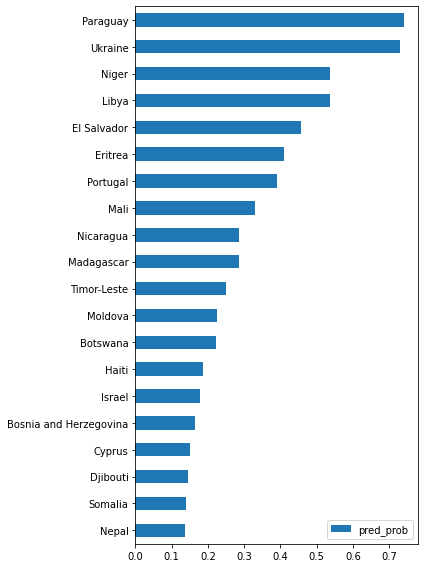

In [115]:
highriskcountries_svm[["pred_prob"]].nlargest(20, columns = ['pred_prob']).sort_values(by = ['pred_prob'], ascending=True).plot(kind='barh', figsize=(6,8), xlabel = '')
save_fig("risk_forecast_2021_svm")
plt.show()

In [135]:
# Compare unique (country) values of 2021 risk forecasts between xgb and svm

pred_2021_xgb = highriskcountries_xgb.nlargest(20, columns = ['pred_prob']).sort_values(by = ['pred_prob'], ascending=False)
countries_2021_xgb = pred_2021_xgb.index.tolist()

pred_2021_svm = highriskcountries_svm.nlargest(20, columns = ['pred_prob']).sort_values(by = ['pred_prob'], ascending=False)
countries_2021_svm = pred_2021_svm.index.tolist()

set_difference = set(countries_2021_xgb) - set(countries_2021_svm)
print(list(set_difference))
print(len(list(set_difference)))

set_same = (set(countries_2021_xgb) & set(countries_2021_svm))
print(set_same)
print(len(list(set_same)))

['Kyrgyzstan', 'Central African Republic', 'Romania', 'Ghana', 'Tanzania', 'Sri Lanka', 'Lesotho', 'Cambodia', 'Guatemala', 'Nigeria', 'Latvia', 'Estonia', 'Chad', 'Brazil', 'Croatia']
15
{'Nepal', 'Mali', 'El Salvador', 'Ukraine', 'Moldova'}
5
